# Analysis of Stan results (from process run on local machine)

### March 16th, 2018

In [44]:
import pandas as pd
#import tabulate as tab
import numpy as np
import matplotlib as mpt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sys
import pystan
import scipy
import pickle

pd.options.display.max_rows = 999
pd.options.display.max_columns = 50


plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.facecolor'] ="white"
plt.rcParams['grid.color'] ="grey"
plt.rcParams['grid.linestyle'] = "dotted"
plt.rcParams["axes.labelsize"]= 25
#plt.rcParams['figure.savefig.dpi'] = 100
plt.rcParams['savefig.edgecolor'] = "#f2f2f2"
plt.rcParams['savefig.facecolor'] ="white"
plt.rcParams["figure.figsize"] = [15,8]
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['font.size'] = 25
greens = ['#66c2a4','#41ae76','#238b45','#006d2c','#00441b']
multi =['#66c2a4','#1f78b4','#a6cee3','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
#plt.rcParams["axes.color_cycle"] = multi

In [2]:
import stan_helpers #get_cent_interval, post_sample

In [3]:
solar_file = open("/Users/johannesmauritzen/research/solar_prod_data/stan_extracts/solar_extr_mac_small.pkl", "rb")
solar_extr = pickle.load(solar_file)


In [4]:
solar_extr.keys()


dict_keys(['meta_mu', 'meta_beta', 'meta_mu_mon', 'sigma_mu1', 'mu_b0', 'sigma_b0', 'sigma_mon', 'sigma_beta', 'sigma', 'b0', 'mu_mon', 'mu1_lease', 'mu1_m', 'mu1_s', 'beta1_cost', 'beta1_size', 'beta1_fy', 'b1'])

In [5]:
mu_leaseDF = pd.DataFrame(solar_extr["mu1_lease"])
mu_leaseDF.columns = ["mu_own", "mu_lease"]
beta_costDF = pd.DataFrame(solar_extr["beta1_cost"])
beta_costDF.columns = ["beta_cost_own", "beta_cost_lease"]
meta_mu = pd.DataFrame(solar_extr["meta_mu"])
meta_mu.columns = ["meta_mu"]
meta_mu_mon = pd.DataFrame(solar_extr["meta_mu_mon"])

In [6]:
mu_leaseDF.head()

,mu_own,mu_lease
0,-0.002265,0.004646
1,-0.009774,-0.001161
2,-0.136516,-0.128102
3,-0.161751,-0.153937
4,-0.118132,-0.108043


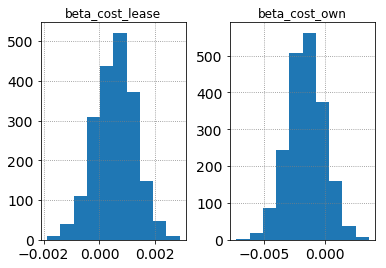

In [7]:
beta_costDF.hist()
plt.show()

In [8]:
beta_costDF.head()

,beta_cost_own,beta_cost_lease
0,-0.000561,0.000856
1,-0.004052,0.001200
2,-0.000792,-0.000122
3,-0.001577,0.000575
4,-0.001146,0.000189


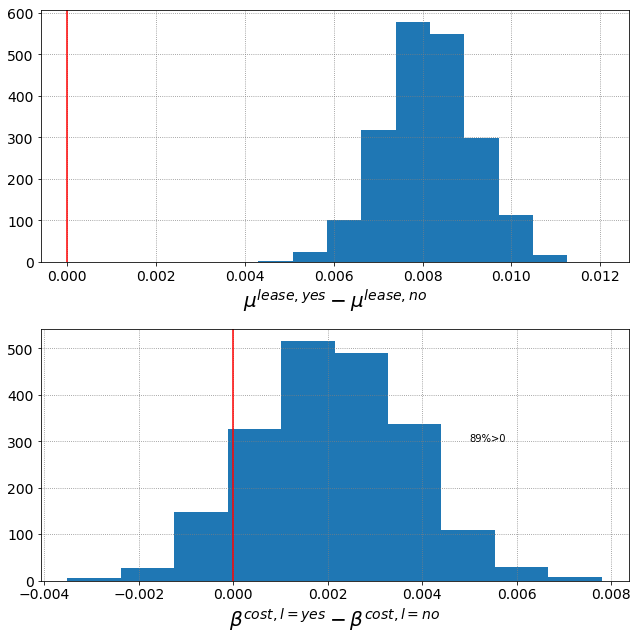

In [9]:


mu_leaseDF["mu_diff"] = mu_leaseDF["mu_lease"]-mu_leaseDF["mu_own"]
beta_costDF["beta_diff"] = beta_costDF["beta_cost_lease"]-beta_costDF["beta_cost_own"]

beta_costDF.head()
beta_costDF.loc[beta_costDF.beta_diff>0, "beta_diff"].size/2000



fig, ax = plt.subplots(2)
mu_leaseDF["mu_diff"].hist(ax=ax[0])
beta_costDF["beta_diff"].hist(ax=ax[1])
ax[0].axvline(x=0, color="red")
ax[1].axvline(x=0, color="red")
fig.set_size_inches(9,9)
#ax[0].set_xlim(-.005, .012)
#ax[1].set_xlim(-.005, .012)
ax[0].set_xlabel(r"$\mu^{lease,yes}- \mu^{lease,no}$")
ax[1].set_xlabel(r"$\beta^{cost,l=yes}- \beta^{cost,l=no}$")
ax[1].text(.005, 300, "89%>0")
plt.savefig("figures/bayes_hypos.png", dpi=100)
plt.tight_layout()
plt.show()

In [10]:
mu_sectDF = pd.DataFrame(solar_extr["mu1_s"])

In [11]:
mu_sectDF.columns = ["Commercial", "Residential", "Government", "Non-profit"]

In [12]:
mu_sectDF["com-res"] = mu_sectDF["Commercial"]-mu_sectDF["Residential"]

In [13]:
mu_sectDF["gov-res"] = mu_sectDF["Government"]-mu_sectDF["Residential"]

In [14]:
mu_sectDF["npr-res"] = mu_sectDF["Non-profit"]-mu_sectDF["Residential"]

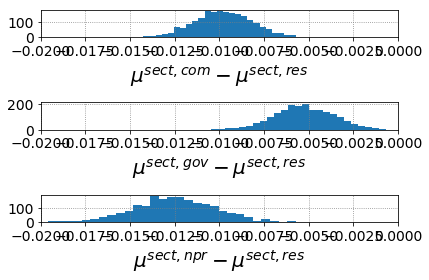

In [15]:
fig, ax = plt.subplots(3)
mu_sectDF["com-res"].hist(bins=30, ax=ax[0])
mu_sectDF["gov-res"].hist(bins=30, ax=ax[1])
mu_sectDF["npr-res"].hist(bins=30, ax=ax[2])
for a in ax:
    a.set_xlim(-.020, 0.000)
ax[0].set_xlabel("$\mu^{sect,com}-\mu^{sect,res}$")
ax[1].set_xlabel("$\mu^{sect,gov}-\mu^{sect,res}$")
ax[2].set_xlabel("$\mu^{sect,npr}-\mu^{sect,res}$")
plt.tight_layout()
fig.savefig("figures/mu_sectors.png")
plt.show()

In [16]:
metakeys = ['meta_mu', 'meta_beta', 'meta_mu_mon', 'sigma_mu1', 'mu_b0', 'sigma_b0', 'sigma_mon', 'sigma_beta', 'sigma', 'mu_mon', 'mu1_lease', 'mu1_s', 'beta1_cost', 'beta1_size', 'beta1_fy']

In [17]:
metakeys

['meta_mu',
 'meta_beta',
 'meta_mu_mon',
 'sigma_mu1',
 'mu_b0',
 'sigma_b0',
 'sigma_mon',
 'sigma_beta',
 'sigma',
 'mu_mon',
 'mu1_lease',
 'mu1_s',
 'beta1_cost',
 'beta1_size',
 'beta1_fy']

In [18]:
def addseries(mkey, extrObj):
    paramDF = pd.DataFrame(extrObj[mkey])
    cols = paramDF.shape[1]
    collabels = [mkey+str(i) for i in range(cols)]
    paramDF.columns = collabels
    return(paramDF)
    

In [19]:
mu_monthDF = addseries("mu_mon", solar_extr)

In [20]:
mu_monthDF

,mu_mon0,mu_mon1,mu_mon2,mu_mon3,mu_mon4,mu_mon5,mu_mon6,mu_mon7,mu_mon8,mu_mon9,mu_mon10,mu_mon11
0,-0.177927,-0.136497,-0.068043,0.025997,0.072330,0.097916,0.094632,0.086782,0.067692,0.011691,-0.045379,-0.137005
1,-0.179760,-0.136937,-0.070659,0.024034,0.070800,0.095098,0.092463,0.085344,0.065909,0.009291,-0.046685,-0.140441
2,-0.186752,-0.144483,-0.076115,0.017244,0.063627,0.088783,0.085823,0.077902,0.060081,0.003668,-0.054201,-0.146540
3,-0.185705,-0.142914,-0.077424,0.018676,0.064783,0.089012,0.085965,0.079989,0.058835,0.002797,-0.052904,-0.144757
4,-0.185751,-0.144191,-0.076469,0.018114,0.064426,0.089916,0.086127,0.078459,0.058810,0.003941,-0.053086,-0.146441
5,-0.185423,-0.143015,-0.076371,0.018185,0.063776,0.088583,0.086288,0.078816,0.058773,0.003038,-0.052364,-0.145562
6,-0.183897,-0.141472,-0.074203,0.019695,0.066494,0.091198,0.088102,0.080291,0.060550,0.004549,-0.051139,-0.143692
7,-0.180044,-0.138189,-0.071793,0.024055,0.069200,0.094240,0.090676,0.084393,0.064753,0.008224,-0.049081,-0.140701
8,-0.183643,-0.140719,-0.073570,0.020308,0.067864,0.091058,0.087768,0.081548,0.061541,0.006421,-0.051398,-0.143453
9,-0.180992,-0.138324,-0.071286,0.023163,0.069493,0.094038,0.089866,0.082941,0.064307,0.008897,-0.047656,-0.140907


In [21]:
higher_paramsDF = addseries(metakeys.pop(), solar_extr)


In [22]:
for mkey in metakeys:
    higher_paramsDF = pd.concat([higher_paramsDF, addseries(mkey, solar_extr)], axis=1)

In [23]:
higher_paramsDF.head()

,beta1_fy0,meta_mu0,meta_beta0,meta_mu_mon0,sigma_mu10,mu_b00,sigma_b00,sigma_mon0,sigma_beta0,sigma0,mu_mon0,mu_mon1,mu_mon2,mu_mon3,mu_mon4,mu_mon5,mu_mon6,mu_mon7,mu_mon8,mu_mon9,mu_mon10,mu_mon11,mu1_lease0,mu1_lease1,mu1_s0,mu1_s1,mu1_s2,mu1_s3,beta1_cost0,beta1_cost1,beta1_size0
0,-0.017686,-0.005082,-0.074228,-0.052473,0.004865,0.008955,0.465265,0.103328,0.467363,0.065422,-0.177927,-0.136497,-0.068043,0.025997,0.072330,0.097916,0.094632,0.086782,0.067692,0.011691,-0.045379,-0.137005,-0.002265,0.004646,-0.014181,-0.005407,-0.011441,-0.017493,-0.000561,0.000856,0.004151
1,-0.017488,-0.004222,-0.036951,-0.001479,0.005560,0.010839,0.475754,0.106339,0.045348,0.065333,-0.179760,-0.136937,-0.070659,0.024034,0.070800,0.095098,0.092463,0.085344,0.065909,0.009291,-0.046685,-0.140441,-0.009774,-0.001161,-0.009797,0.000885,-0.005362,-0.011203,-0.004052,0.001200,0.003230
2,-0.017040,0.056340,1.139436,-0.006766,0.005937,0.010066,0.486081,0.113263,2.560161,0.065357,-0.186752,-0.144483,-0.076115,0.017244,0.063627,0.088783,0.085823,0.077902,0.060081,0.003668,-0.054201,-0.146540,-0.136516,-0.128102,0.057613,0.067518,0.061574,0.054565,-0.000792,-0.000122,0.003444
3,-0.018519,0.071119,0.101228,-0.041611,0.005252,0.021237,0.477129,0.114344,2.575146,0.065398,-0.185705,-0.142914,-0.077424,0.018676,0.064783,0.089012,0.085965,0.079989,0.058835,0.002797,-0.052904,-0.144757,-0.161751,-0.153937,0.066997,0.074640,0.072363,0.064546,-0.001577,0.000575,0.002145
4,-0.018096,0.047931,0.006776,-0.073413,0.005947,0.019272,0.475721,0.125948,0.005732,0.065478,-0.185751,-0.144191,-0.076469,0.018114,0.064426,0.089916,0.086127,0.078459,0.058810,0.003941,-0.053086,-0.146441,-0.118132,-0.108043,0.044126,0.054535,0.050652,0.044193,-0.001146,0.000189,0.000875


In [24]:
#Get median, mode and 95 percentiles 
higher_params_summary = higher_paramsDF.describe(percentiles=[.025, .25, .5,.75,.975])

In [25]:
higher_params_summary = higher_params_summary.drop("count", axis=0)


In [26]:
higher_params_summary

,beta1_fy0,meta_mu0,meta_beta0,meta_mu_mon0,sigma_mu10,mu_b00,sigma_b00,sigma_mon0,sigma_beta0,sigma0,mu_mon0,mu_mon1,mu_mon2,mu_mon3,mu_mon4,mu_mon5,mu_mon6,mu_mon7,mu_mon8,mu_mon9,mu_mon10,mu_mon11,mu1_lease0,mu1_lease1,mu1_s0,mu1_s1,mu1_s2,mu1_s3,beta1_cost0,beta1_cost1,beta1_size0
mean,-0.017742,0.004472,0.002901,0.005174,0.005696,-0.000128,0.476254,0.114111,0.833029,0.065305,-0.163741,-0.121183,-0.054173,0.040417,0.086596,0.111363,0.108396,0.101407,0.081896,0.025660,-0.031106,-0.123320,-0.029895,-0.021745,0.001769,0.011548,0.006303,-0.000950,-0.001541,0.000551,0.002372
std,0.001005,0.022468,0.838052,0.036476,0.001148,0.015365,0.006140,0.029594,1.772813,0.000109,0.013047,0.013054,0.013049,0.013054,0.013050,0.013057,0.013074,0.013065,0.013072,0.013062,0.013046,0.013051,0.044812,0.044754,0.022443,0.022466,0.022490,0.022470,0.001526,0.000727,0.001045
min,-0.021234,-0.018128,-8.119737,-0.137944,0.002894,-0.042774,0.454422,0.058861,0.001353,0.064943,-0.187785,-0.145610,-0.078019,0.016516,0.063023,0.087415,0.084106,0.077367,0.057536,0.001718,-0.055532,-0.146828,-0.193442,-0.186281,-0.023657,-0.013646,-0.017009,-0.025849,-0.007263,-0.001871,-0.001322
2.5%,-0.019717,-0.010050,-1.707059,-0.065188,0.003790,-0.027964,0.464840,0.073577,0.005921,0.065099,-0.185887,-0.143210,-0.076369,0.018198,0.064425,0.089217,0.086159,0.079283,0.059754,0.003547,-0.053050,-0.145566,-0.159237,-0.150697,-0.014949,-0.005200,-0.010246,-0.018189,-0.004556,-0.000920,0.000332
25%,-0.018418,-0.006745,-0.074372,-0.019411,0.004879,-0.011726,0.471995,0.093590,0.046698,0.065236,-0.173153,-0.130550,-0.063975,0.030881,0.077169,0.101535,0.098622,0.091632,0.072350,0.016153,-0.041236,-0.132774,-0.015417,-0.007412,-0.009705,-0.000023,-0.005207,-0.012428,-0.002555,0.000062,0.001650
50%,-0.017731,-0.004875,-0.006739,0.005845,0.005590,-0.001511,0.476186,0.108323,0.195300,0.065303,-0.162558,-0.119999,-0.052877,0.041723,0.087923,0.112651,0.109693,0.102585,0.083080,0.026859,-0.029948,-0.122023,-0.011114,-0.003019,-0.007150,0.002531,-0.002756,-0.009864,-0.001545,0.000572,0.002392
75%,-0.017063,-0.002291,0.075168,0.029673,0.006420,0.011282,0.480444,0.127513,0.836010,0.065377,-0.153707,-0.111136,-0.044064,0.050611,0.096773,0.121403,0.118437,0.111576,0.092034,0.035752,-0.020988,-0.113243,-0.007946,0.000169,-0.003708,0.006432,0.000826,-0.006041,-0.000524,0.001044,0.003063
97.5%,-0.015798,0.069458,1.738082,0.075358,0.008327,0.031133,0.488055,0.185232,5.675391,0.065533,-0.144094,-0.101528,-0.034568,0.059938,0.106336,0.130976,0.128104,0.121038,0.101564,0.045212,-0.011442,-0.103707,-0.001981,0.006123,0.066214,0.075195,0.071288,0.063369,0.001344,0.001966,0.004403
max,-0.014175,0.084065,6.787015,0.146111,0.011334,0.043573,0.495446,0.340774,19.879458,0.065672,-0.142283,-0.099872,-0.032893,0.061797,0.108069,0.133098,0.129757,0.123048,0.103379,0.047211,-0.009829,-0.101366,0.014799,0.023143,0.087392,0.096418,0.091744,0.083697,0.003619,0.002868,0.005928


In [27]:
higher_params_summary.transpose().to_latex(buf="higher_params_summary_table.tex", float_format="%.3f'")

### Manufacturer

In [28]:
mu_mDF = addseries("mu1_m", solar_extr)

In [29]:
mu_mDF

,mu1_m0,mu1_m1,mu1_m2,mu1_m3,mu1_m4,mu1_m5,mu1_m6,mu1_m7,mu1_m8,mu1_m9,mu1_m10,mu1_m11,mu1_m12,mu1_m13,mu1_m14,mu1_m15,mu1_m16,mu1_m17,mu1_m18,mu1_m19,mu1_m20,mu1_m21,mu1_m22,mu1_m23,mu1_m24,...,mu1_m82,mu1_m83,mu1_m84,mu1_m85,mu1_m86,mu1_m87,mu1_m88,mu1_m89,mu1_m90,mu1_m91,mu1_m92,mu1_m93,mu1_m94,mu1_m95,mu1_m96,mu1_m97,mu1_m98,mu1_m99,mu1_m100,mu1_m101,mu1_m102,mu1_m103,mu1_m104,mu1_m105,mu1_m106
0,-0.002093,-0.003950,-0.006179,-0.006753,-0.004851,-0.003710,-0.007352,0.000223,-0.003216,-0.005926,-0.193450,-0.010100,-0.008621,-0.006853,-0.003574,-5.092624e-03,-0.007280,-3.757579e-03,-0.005498,-0.007704,-0.005142,-0.006426,-0.002131,-0.012265,-0.026496,...,-0.002523,-0.043956,-0.020574,-0.010257,0.036641,-0.001961,-0.006254,-0.005648,-0.010920,0.000798,-0.003363,-0.003894,-0.005302,-0.003876,-0.002667,-7.897409e-03,-0.002761,0.002059,-6.226336e-03,0.004474,-0.053379,-0.004498,-0.008080,-0.003367,-0.001540
1,0.000296,-0.000270,-0.005144,-0.000217,-0.003140,-0.018981,-0.005983,0.001021,-0.001866,-0.007420,-0.179669,-0.005553,-0.016277,-0.003671,-0.002153,-1.418436e-03,-0.001663,2.168740e-03,0.000275,-0.002056,-0.004820,-0.004586,-0.000538,-0.027986,-0.023887,...,-0.008384,-0.010178,-0.031540,-0.009744,0.060652,-0.009201,-0.027100,-0.002861,-0.006762,0.022580,0.002302,-0.005047,0.009134,0.001054,0.013650,1.043026e-02,-0.001896,-0.007854,-1.190325e-02,-0.002215,-0.062619,-0.012727,0.004775,-0.007299,-0.006182
2,0.060713,0.058541,0.056509,0.055951,0.058174,0.054226,0.052430,0.063353,0.060162,0.055160,-0.123075,0.054513,0.038236,0.057858,0.056724,5.568534e-02,0.055789,5.474467e-02,0.060136,0.054200,0.056635,0.055478,0.065476,0.048421,0.041513,...,0.054674,0.057223,0.040573,0.042920,0.169333,0.060591,0.047520,0.058518,0.073040,0.059182,0.065576,0.065673,0.056567,0.061180,0.057770,5.486820e-02,0.051397,0.084219,5.959131e-02,0.056506,0.019250,0.038640,0.053918,0.050388,0.053310
3,0.076605,0.073306,0.067551,0.070147,0.073044,0.068523,0.068864,0.076450,0.074477,0.076327,-0.069570,0.068778,0.061449,0.073762,0.072706,7.390950e-02,0.070451,6.877391e-02,0.078643,0.065874,0.070665,0.070216,0.068859,0.064765,0.064486,...,0.069571,0.080840,0.072968,0.029205,0.073705,0.070542,0.066814,0.072263,0.090133,0.074204,0.069486,0.081080,0.067372,0.068228,0.073527,7.367513e-02,0.075762,0.061356,7.743108e-02,0.096377,0.044860,0.052368,0.077717,0.064770,0.068913
4,0.055082,0.052015,0.048482,0.048847,0.051564,0.051217,0.046436,0.058604,0.048458,0.051093,-0.107901,0.046876,0.044946,0.049321,0.052863,5.328733e-02,0.048678,5.108854e-02,0.055566,0.049557,0.050779,0.047654,0.050284,0.045974,0.041936,...,0.036105,0.039963,0.002690,0.041000,0.121662,0.051154,0.046900,0.060753,0.044090,0.064806,0.067464,0.053413,0.058176,0.058205,0.040003,5.210338e-02,0.020334,0.053574,4.861629e-02,0.069707,0.010991,0.046131,0.055355,0.048743,0.041887
5,0.045969,0.045428,0.039576,0.047927,0.044192,0.004090,0.041482,0.051648,0.044276,0.048448,-0.160194,0.040009,0.040972,0.043506,0.047688,4.453944e-02,0.045705,4.486254e-02,0.039556,0.037294,0.045235,0.042599,0.042400,0.032535,0.030476,...,0.044071,0.037681,0.009778,0.044927,0.137975,0.040753,0.031588,0.036786,0.039111,0.056938,0.039444,0.039573,0.046875,0.031631,0.052723,5.229967e-02,0.038410,0.042984,3.565917e-02,0.050930,0.002377,0.032224,0.040996,0.043456,0.036675
6,0.084488,0.083031,0.076469,0.080345,0.080879,0.068402,0.077703,0.087457,0.087002,0.080950,-0.072258,0.079152,0.064007,0.082806,0.084142,8.305156e-02,0.081055,8.546828e-02,0.081817,0.078484,0.079397,0.078140,0.079114,0.067778,0.051714,...,0.084126,0.057936,0.046486,0.058353,0.122554,0.078947,0.086833,0.080817,0.103823,0.073488,0.070385,0.080409,0.080377,0.080075,0.082451,8.064896e-02,0.087856,0.077119,7.728213e-02,0.099818,0.055851,0.076212,0.091673,0.077307,0.077782
7,0.040327,0.037964,0.038062,0.036674,0.039085,0.036034,0.033670,0.042748,0.044243,0.044759,-0.118749,0.033818,0.033337,0.036680,0.040661,3.802466e-02,0.033777,4.073531e-02,0.040294,0.037237,0.035119,0.0358

In [30]:
sns.set(style="whitegrid")
networks = sns.load_dataset("brain_networks", index_col=0, header=[0, 1, 2])



In [31]:
networks.head()

network          1                     2                     3             \
node             1                     1                     1              
hemi            lh         rh         lh         rh         lh         rh   
0        56.055744  92.031036   3.391576  38.659683  26.203819 -49.715569   
1        55.547253  43.690075 -65.495987 -13.974523 -28.274963 -39.050129   
2        60.997768  63.438793 -51.108582 -13.561346 -18.842947  -1.214659   
3        18.514868  12.657158 -34.576603 -32.665958  -7.420454  17.119448   
4        -2.527392 -63.104668 -13.814151 -15.837989 -45.216927   3.483550   

network          4                     5                     6             \
node             1                     1                     1              
hemi            lh         rh         lh         rh         lh         rh   
0        47.461037  26.746613 -35.898861  -1.889181   5.898688 -43.692322   
1        -1.210660 -19.012897  19.568010  15.902983 -23.231823 -10.745867   
2       -65.575806 -85.777428  19.247454  37.209419   2.392153  16.509109   
3       -41.800869 -58.610184  32.896915  11.199619 -14.665752   2.073715   
4       -62.613335 -49.076508  18.396759   3.219077 -41.856911 -24.690414   

network                                7                                   \
node             2                     1                     2              
hemi            lh         rh         lh         rh         lh         rh   
0       -47.664265  12.284122   1.566538 -13.042585  -1.855260 -39.805901   
1        10.269546  31.275831 -26.309488 -18.077026 -10.259323 -43.488678   
2        -5.314236   2.372976  -7.342168 -24.550989   1.774612  32.257950   
3        32.634335  45.825409 -47.632999  -6.580215  -2.768599 -25.282215   
4       -33.975418 -24.149668  -6.315651 -29.344135 -52.696259 -41.713947   

network                                 8                                   \
node             3                      1                     2              
hemi            lh         rh          lh         rh         lh         rh   
0       -30.831512 -61.137009  -25.827856  39.024162 -29.971645  -6.132372   
1       -63.965630  47.789856   -7.910675  37.951271  -9.677254 -52.373508   
2        -1.835028 -29.464401  -74.943153 -15.261617  25.806980 -46.593338   
3       -14.930727  10.123429 -106.994080 -21.723146 -20.490711  11.527937   
4       -13.849936 -58.447361   23.605339  24.290478  32.855915 -19.030916   

network             ...         13                                   \
node             3  ...          1                     2              
hemi            lh  ...         lh         rh         lh         rh   
0       -56.756989  ... -18.968014  14.880836 -47.754597  14.738475   
1         6.007476  ... -64.506470   4.348629 -84.354919  23.792282   
2        25.265587  ... -53.985542 -21.308418 -64.170738   8.968520   
3       -68.262657  ... -41.107334 -17.331886 -40.612820  19.627728   
4        -2.603484  ... -18.740891 -10.787350  34.943150  55.853088   

network                               14                    15             \
node             3          4          1                     1              
hemi            rh         rh         lh         rh         lh         rh   
0       -16.853010 -34.217819 -66.330696  -5.723309 -32.081429 -76.854546   
1         8.927007 -19.732401  25.679350  22.786358 -13.500934 -12.818995   
2         1.413584  -4.955075  29.660667 -14.237561  15.600105 -28.891750   
3        49.208748   1.661293  58.214813  11.480132  38.754799   6.445356   
4        46.737320   4.586625  -5.739993   5.046614  38.816483  38.395302   

network         16                                                         \
node             1                     2                     3              
hemi            lh         rh         lh         rh         lh         rh   
0        13.468185  68.456291  19.311008  30.178928  60.526405   0.607904   
1        58.723301  73.054916 

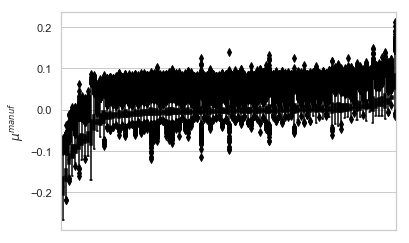

In [32]:
order = mu_mDF.mean().sort_values().index
manPlot = sns.boxplot(data=mu_mDF, order=order, color="Black")
manPlot.axes.xaxis.set_ticklabels([])
manPlot.axes.set_ylabel("$\mu^{manuf}$")
manPlot.figure.savefig("figures/BayManPlot", dpi=300)
plt.show()

In [33]:
b0DF = addseries("b0", solar_extr)
b1DF = addseries("b1", solar_extr)

In [34]:
b0DF.head()

,b00,b01,b02,b03,b04,b05,b06,b07,b08,b09,b010,b011,b012,b013,b014,b015,b016,b017,b018,b019,b020,b021,b022,b023,b024,...,b03120,b03121,b03122,b03123,b03124,b03125,b03126,b03127,b03128,b03129,b03130,b03131,b03132,b03133,b03134,b03135,b03136,b03137,b03138,b03139,b03140,b03141,b03142,b03143,b03144
0,0.228087,-0.773374,0.353486,0.161749,0.417069,0.450694,-0.199846,-0.254464,-0.185644,-0.138505,0.149219,0.386722,0.300754,0.313133,-0.775306,0.718261,-0.238319,-0.196003,-0.564662,-0.979315,-0.751205,-1.030960,0.771187,0.420713,0.050346,...,0.237035,-0.142299,-0.151147,0.182541,0.374104,-0.007119,0.231514,0.747928,0.507864,0.084293,0.051615,0.118232,-0.177472,0.312771,0.060873,0.153839,0.089366,0.417848,0.686125,-0.441486,0.692835,-0.267061,-0.021962,0.766516,0.002509
1,0.234403,-0.768943,0.357855,0.158751,0.429793,0.475676,-0.193667,-0.254677,-0.180834,-0.146562,0.157894,0.400584,0.307896,0.308475,-0.773811,0.726391,-0.233831,-0.201775,-0.579881,-0.978245,-0.769591,-1.045837,0.780047,0.420258,0.051690,...,0.214905,-0.140005,-0.139281,0.182822,0.409803,0.004820,0.225962,0.738764,0.514801,0.097896,0.064927,0.106487,-0.167615,0.306876,0.069489,0.157362,0.070000,0.438441,0.697350,-0.413193,0.710223,-0.255808,-0.019111,0.746802,0.007526
2,0.245486,-0.759834,0.369070,0.194747,0.431957,0.471886,-0.197070,-0.240284,-0.159352,-0.131565,0.166140,0.405382,0.302751,0.307666,-0.761775,0.734757,-0.216232,-0.178752,-0.570221,-0.975418,-0.755493,-1.017619,0.776902,0.423057,0.069149,...,0.243369,-0.130246,-0.143731,0.194782,0.398807,-0.004919,0.228210,0.717464,0.523819,0.115031,0.087087,0.117951,-0.180594,0.292866,0.084709,0.154245,0.086761,0.435547,0.712814,-0.446913,0.702328,-0.237435,-0.021126,0.770412,0.025671
3,0.219150,-0.768762,0.367044,0.160955,0.442462,0.441816,-0.180793,-0.250161,-0.198738,-0.139652,0.148479,0.389609,0.319008,0.331491,-0.771336,0.738669,-0.246497,-0.199847,-0.558707,-0.974881,-0.752651,-1.031073,0.784456,0.426200,0.062843,...,0.235559,-0.131974,-0.144440,0.185789,0.404129,0.001055,0.243650,0.762262,0.530500,0.087948,0.072946,0.114800,-0.135911,0.341948,0.073164,0.168670,0.100743,0.441190,0.687148,-0.419048,0.710708,-0.265233,-0.012565,0.787100,0.029659
4,0.229380,-0.771929,0.341452,0.184541,0.432016,0.469215,-0.208491,-0.253114,-0.185776,-0.129625,0.160923,0.400305,0.310608,0.313804,-0.762780,0.729007,-0.223878,-0.190598,-0.574489,-0.978303,-0.760273,-1.029216,0.786593,0.428118,0.067849,...,0.224700,-0.137485,-0.153781,0.201487,0.395504,0.003927,0.226899,0.747081,0.530399,0.089444,0.064694,0.122564,-0.158561,0.309018,0.083315,0.165843,0.102567,0.420619,0.699200,-0.433219,0.697582,-0.261359,-0.015601,0.765982,0.014714


In [35]:
b0DF_summ = b0DF.describe(percentiles=[.025,.975])
b1DF_summ = b1DF.describe(percentiles=[.025,.975])

In [36]:
b0DF_summ = b0DF_summ.transpose()
b1DF_summ = b1DF_summ.transpose()

In [37]:
b0DF_summ.head()

,count,mean,std,min,2.5%,50%,97.5%,max
b00,2000.0,0.209362,0.015381,0.170334,0.182228,0.208211,0.239693,0.264001
b01,2000.0,-0.789632,0.015621,-0.833295,-0.818007,-0.790844,-0.760644,-0.748307
b02,2000.0,0.342369,0.015887,0.293394,0.314010,0.341115,0.374778,0.390003
b03,2000.0,0.154555,0.015780,0.115218,0.127004,0.153587,0.185224,0.196004
b04,2000.0,0.414027,0.015957,0.371222,0.385928,0.412745,0.446005,0.456277


In [38]:
b0DF_summ.shape[0]


3145

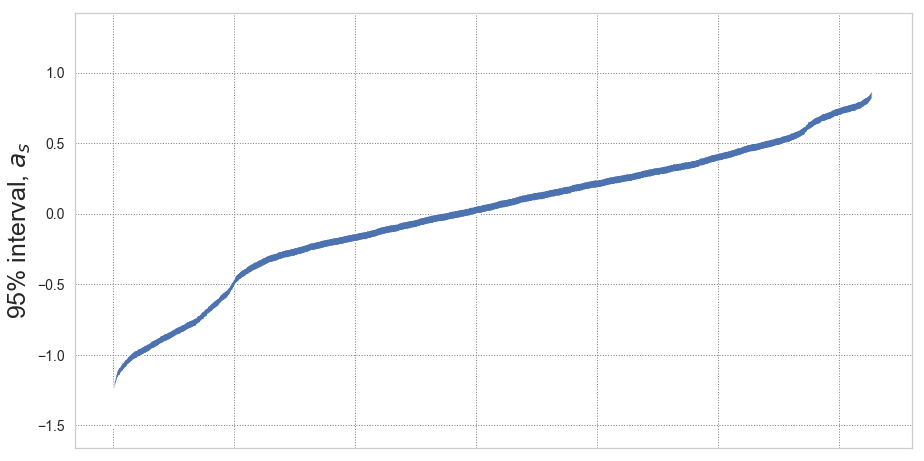

In [45]:
b0DF_summ = b0DF_summ.sort_values("50%")
b0DF_summ["ord"]=[i for i in range(b0DF_summ.shape[0])]
fig, ax = plt.subplots()
ax.fill_between(b0DF_summ["ord"], b0DF_summ["2.5%"], b0DF_summ["97.5%"])
ax.xaxis.set_ticklabels([])
ax.set_ylabel("95% interval, $a_s$")
fig.savefig("figures/Bay_as.png", dpi=300)
plt.show()

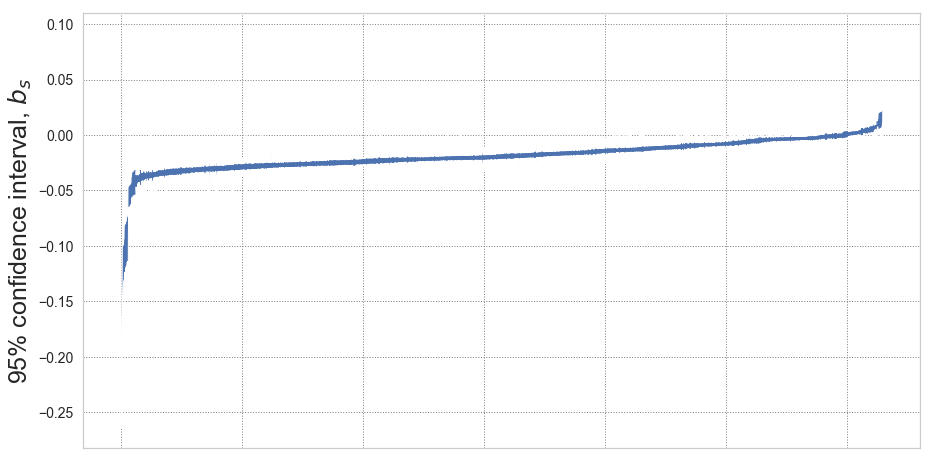

In [46]:
b1DF_summ = b1DF_summ.sort_values("50%")
b1DF_summ["ord"]=[i for i in range(b0DF_summ.shape[0])]
fig, ax = plt.subplots()
ax.fill_between(b1DF_summ["ord"], b1DF_summ["2.5%"], b1DF_summ["97.5%"])
ax.xaxis.set_ticklabels([])
ax.set_ylabel("95% confidence interval, $b_s$")
fig.savefig("figures/Bay_bs.png", dpi=300)
plt.show()